# Master EDA for IMDb datasets

This notebook performs comprehensive exploratory data analysis over three preprocessed IMDb datasets:

- `imdb_clean.csv`: movie-level cleaned dataset
- `imdb_cast_exploded.csv`: cast exploded dataset (one row per cast member)
- `imdb_genre_exploded.csv`: genre exploded dataset (one row per genre)

We will explore distributions, correlations, cast/genre stats, yearly trends, scatter plots, and boxplots.


## Setup and data loading


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

clean_path = 'imdb_clean.csv'
cast_path = 'imdb_cast_exploded.csv'
genre_path = 'imdb_genre_exploded.csv'

df_clean = pd.read_csv(clean_path)
df_cast = pd.read_csv(cast_path)
df_genre = pd.read_csv(genre_path)

print('df_clean shape:', df_clean.shape)
print('df_cast shape:', df_cast.shape)
print('df_genre shape:', df_genre.shape)

df_clean.head(3)

df_clean shape: (10000, 11)
df_cast shape: (40758, 11)
df_genre shape: (25128, 11)


,title,year,certificate,duration,genre,rating,metascore,director,cast,votes,review_count
0,The Idea of You,2023.0,R,115,"['Comedy', 'Drama', 'Romance']",6.4,67.0,Michael Showalter,"['Anne Hathaway', 'Nicholas Galitzine', 'Ella ...","28,744",166
1,Kingdom of the Planet of the Apes,2023.0,PG-13,145,"['Action', 'Adventure', 'Sci-Fi']",7.3,66.0,Wes Ball,"['Owen Teague', 'Freya Allan', 'Kevin Durand',...","22,248",183
2,Unfrosted,2023.0,PG-13,97,"['Biography', 'Comedy', 'History']",5.5,42.0,Jerry Seinfeld,"['Isaac Bae', 'Jerry Seinfeld', 'Chris Rickett...","18,401",333


## Column standardization check

Ensure key columns exist and are standardized (meta_score, duration, year, cast, genre). If not, try to normalize them.


In [8]:
def normalize_columns(df):
    df.columns = (
        df.columns.str.lower()
                  .str.strip()
                  .str.replace(' ', '_')
                  .str.replace('\n', '_')
                  .str.replace('\r', '')
                  .str.replace('\t', '_')
    )
    return df

df_clean = normalize_columns(df_clean)
df_cast = normalize_columns(df_cast)
df_genre = normalize_columns(df_genre)

# Ensure duration_ -> duration if needed
if 'duration_' in df_clean.columns and 'duration' not in df_clean.columns:
    df_clean = df_clean.rename(columns={'duration_': 'duration'})

print('df_clean columns:', df_clean.columns.tolist())
print('df_cast columns:', df_cast.columns.tolist())
print('df_genre columns:', df_genre.columns.tolist())

df_clean columns: ['title', 'year', 'certificate', 'duration', 'genre', 'rating', 'metascore', 'director', 'cast', 'votes', 'review_count']
df_cast columns: ['title', 'year', 'certificate', 'duration', 'genre', 'rating', 'metascore', 'director', 'cast', 'votes', 'review_count']
df_genre columns: ['title', 'year', 'certificate', 'duration', 'genre', 'rating', 'metascore', 'director', 'cast', 'votes', 'review_count']


## Type assurance for numeric columns

Convert `meta_score`, `duration`, `year` to numeric and handle missing values robustly for EDA comparability.


In [9]:
num_cols = ['meta_score', 'duration', 'year']
for col in num_cols:
    if col in df_clean.columns:
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
        df_clean[col] = df_clean[col].fillna(df_clean[col].median())

for col in num_cols:
    if col in df_cast.columns:
        df_cast[col] = pd.to_numeric(df_cast[col], errors='coerce')
        df_cast[col] = df_cast[col].fillna(df_cast[col].median())

for col in num_cols:
    if col in df_genre.columns:
        df_genre[col] = pd.to_numeric(df_genre[col], errors='coerce')
        df_genre[col] = df_genre[col].fillna(df_genre[col].median())

# Cast duration and year to int where present (meta_score can stay float)
for df_ in [df_clean, df_cast, df_genre]:
    if 'duration' in df_.columns:
        df_['duration'] = df_['duration'].astype(int)
    if 'year' in df_.columns:
        df_['year'] = df_['year'].astype(int)

df_clean.head(3)

,title,year,certificate,duration,genre,rating,metascore,director,cast,votes,review_count
0,The Idea of You,2023,R,115,"['Comedy', 'Drama', 'Romance']",6.4,67.0,Michael Showalter,"['Anne Hathaway', 'Nicholas Galitzine', 'Ella ...","28,744",166
1,Kingdom of the Planet of the Apes,2023,PG-13,145,"['Action', 'Adventure', 'Sci-Fi']",7.3,66.0,Wes Ball,"['Owen Teague', 'Freya Allan', 'Kevin Durand',...","22,248",183
2,Unfrosted,2023,PG-13,97,"['Biography', 'Comedy', 'History']",5.5,42.0,Jerry Seinfeld,"['Isaac Bae', 'Jerry Seinfeld', 'Chris Rickett...","18,401",333


## Missing values overview for each dataset


In [10]:
print('Missing values: df_clean')
print(df_clean.isnull().sum().sort_values(ascending=False).head(20))
print('\nMissing values: df_cast')
print(df_cast.isnull().sum().sort_values(ascending=False).head(20))
print('\nMissing values: df_genre')
print(df_genre.isnull().sum().sort_values(ascending=False).head(20))

Missing values: df_clean
metascore       2445
rating           404
title              0
year               0
certificate        0
duration           0
genre              0
director           0
cast               0
votes              0
review_count       0
dtype: int64

Missing values: df_cast
metascore       9791
rating          1424
cast              39
title              0
year               0
certificate        0
duration           0
genre              0
director           0
votes              0
review_count       0
dtype: int64

Missing values: df_genre
metascore       5639
rating           908
genre              7
title              0
year               0
certificate        0
duration           0
director           0
cast               0
votes              0
review_count       0
dtype: int64


## Summary statistics for each dataset


In [11]:
display(df_clean.describe(include='all').transpose())
display(df_cast.describe(include='all').transpose())
display(df_genre.describe(include='all').transpose())

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
title,10000,9634,The Mummy,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
year,10000.0,NaN,NaN,NaN,2006.47,16.872391,1962.0,1997.0,2012.0,2020.25,2025.0
certificate,10000,31,Unknown,2630,NaN,NaN,NaN,NaN,NaN,NaN,NaN
duration,10000.0,NaN,NaN,NaN,107.7286,17.72893,60.0,95.0,105.0,118.0,152.0
genre,10000,476,['Drama'],504,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rating,9596.0,NaN,NaN,NaN,6.448583,1.01956,3.7,5.8,6.5,7.2,9.3
metascore,7555.0,NaN,NaN,NaN,58.072435,17.832816,7.25,45.5,58.0,71.0,100.0
director,10000,4550,Clint Eastwood,35,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cast,10000,9907,[],39,NaN,NaN,NaN,NaN,NaN,NaN,NaN
votes,10000,9130,Unknown,404,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
title,40758,9634,The ABCs of Death,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
year,40758.0,NaN,NaN,NaN,2006.490211,16.84654,1962.0,1997.0,2012.0,2021.0,2025.0
certificate,40758,31,Unknown,10550,NaN,NaN,NaN,NaN,NaN,NaN,NaN
duration,40758.0,NaN,NaN,NaN,107.628809,17.782045,60.0,95.0,105.0,118.0,152.0
genre,40758,476,['Drama'],2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rating,39334.0,NaN,NaN,NaN,6.449153,1.020998,3.7,5.8,6.5,7.2,9.3
metascore,30967.0,NaN,NaN,NaN,58.127563,17.85286,7.25,46.0,58.0,71.0,100.0
director,40758,4550,Clint Eastwood,140,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cast,40719,17404,Nicolas Cage,74,NaN,NaN,NaN,NaN,NaN,NaN,NaN
votes,40758,9130,Unknown,1424,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
title,25128,9634,A Star Is Born,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN
year,25128.0,NaN,NaN,NaN,2006.510108,16.843885,1962.0,1997.0,2012.0,2020.0,2025.0
certificate,25128,31,Unknown,5986,NaN,NaN,NaN,NaN,NaN,NaN,NaN
duration,25128.0,NaN,NaN,NaN,108.220829,17.72384,60.0,95.0,105.0,118.0,152.0
genre,25121,22,Drama,5304,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rating,24220.0,NaN,NaN,NaN,6.458105,1.001623,3.7,5.9,6.5,7.2,9.3
metascore,19489.0,NaN,NaN,NaN,57.851865,17.60983,7.25,45.0,58.0,71.0,100.0
director,25128,4550,Clint Eastwood,90,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cast,25128,9907,[],87,NaN,NaN,NaN,NaN,NaN,NaN,NaN
votes,25128,9130,Unknown,908,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Distributions of numeric columns (movie-level)


<Figure size 1200x600 with 0 Axes>

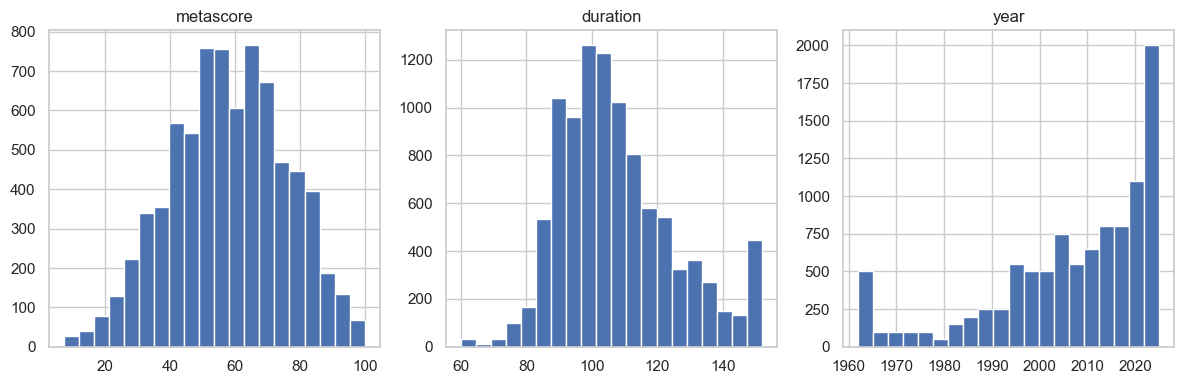

In [12]:
plt.figure(figsize=(12,6))
df_clean[['metascore','duration','year']].hist(bins=20, layout=(1,3), figsize=(12,4))
plt.tight_layout()
plt.show()

## Correlation heatmaps (movie-level, cast-level, genre-level)


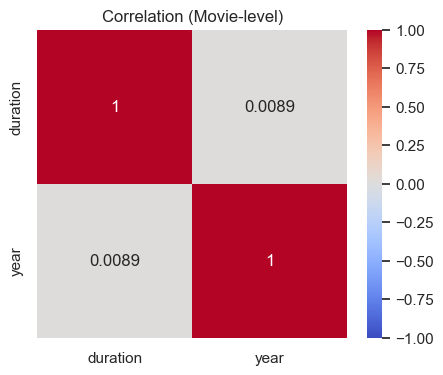

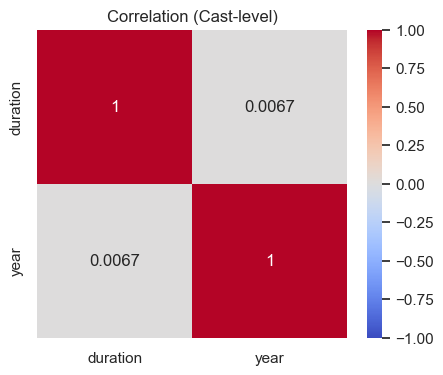

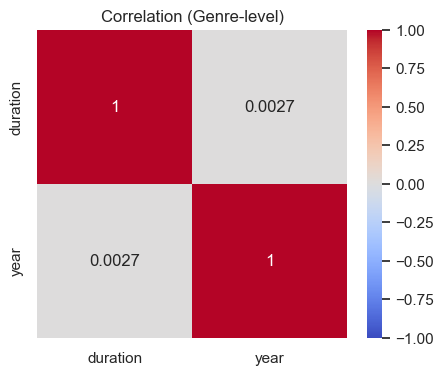

In [13]:
def corr_heatmap(df_, title):
    cols = [c for c in ['meta_score','duration','year'] if c in df_.columns]
    if len(cols) >= 2:
        plt.figure(figsize=(5,4))
        sns.heatmap(df_[cols].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
        plt.title(title)
        plt.show()
    else:
        print(f'Skipping heatmap for {title}: insufficient numeric columns')

corr_heatmap(df_clean, 'Correlation (Movie-level)')
corr_heatmap(df_cast, 'Correlation (Cast-level)')
corr_heatmap(df_genre, 'Correlation (Genre-level)')

## Cast analysis: frequency and average meta score per actor


/var/folders/34/p366zx5n61gbpz187v7lmfw00000gn/T/ipykernel_67412/3026110669.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_cast.index, x=top_cast.values, palette='viridis')


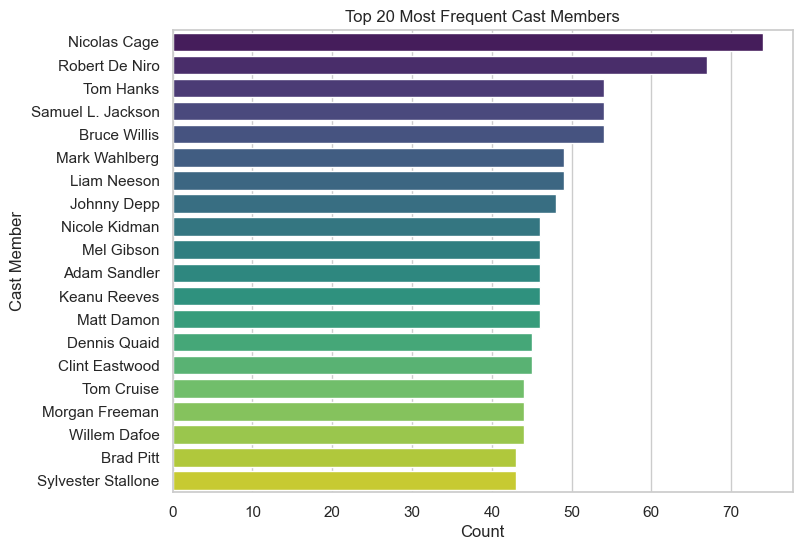

In [14]:
if 'cast' in df_cast.columns:
    top_cast = df_cast['cast'].value_counts().head(20)
    plt.figure(figsize=(8,6))
    sns.barplot(y=top_cast.index, x=top_cast.values, palette='viridis')
    plt.title('Top 20 Most Frequent Cast Members')
    plt.xlabel('Count')
    plt.ylabel('Cast Member')
    plt.show()

    if 'meta_score' in df_cast.columns:
        cast_scores = df_cast.groupby('cast')['meta_score'].mean().sort_values(ascending=False).head(20)
        plt.figure(figsize=(8,6))
        cast_scores.plot(kind='barh', color='teal')
        plt.title('Top Cast by Average Meta Score (Top 20)')
        plt.xlabel('Average Meta Score')
        plt.ylabel('Cast Member')
        plt.gca().invert_yaxis()
        plt.show()
else:
    print('No cast column found in df_cast')

## Genre analysis: frequency and average meta score per genre


/var/folders/34/p366zx5n61gbpz187v7lmfw00000gn/T/ipykernel_67412/2388976532.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_genre.index, x=top_genre.values, palette='magma')


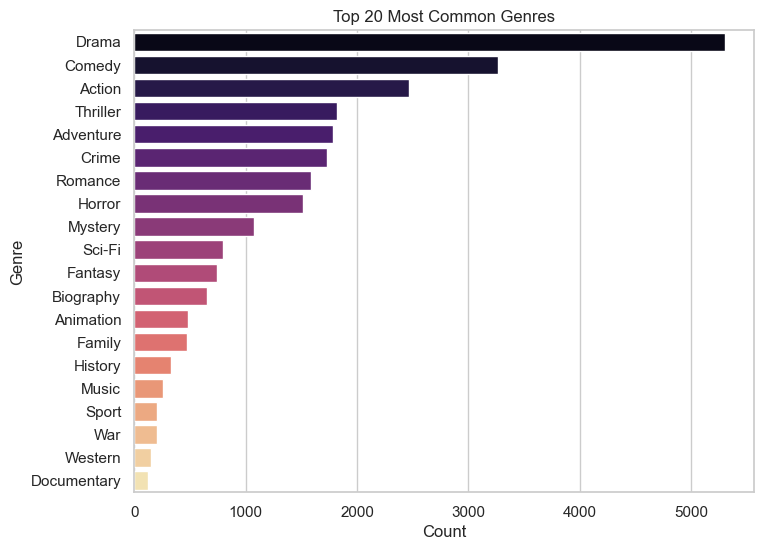

In [15]:
if 'genre' in df_genre.columns:
    top_genre = df_genre['genre'].value_counts().head(20)
    plt.figure(figsize=(8,6))
    sns.barplot(y=top_genre.index, x=top_genre.values, palette='magma')
    plt.title('Top 20 Most Common Genres')
    plt.xlabel('Count')
    plt.ylabel('Genre')
    plt.show()

    if 'meta_score' in df_genre.columns:
        genre_scores = df_genre.groupby('genre')['meta_score'].mean().sort_values(ascending=False).head(20)
        plt.figure(figsize=(8,6))
        genre_scores.plot(kind='barh', color='salmon')
        plt.title('Top Genres by Average Meta Score (Top 20)')
        plt.xlabel('Average Meta Score')
        plt.ylabel('Genre')
        plt.gca().invert_yaxis()
        plt.show()
else:
    print('No genre column found in df_genre')

## Yearly trends: volume and average duration (movie-level)


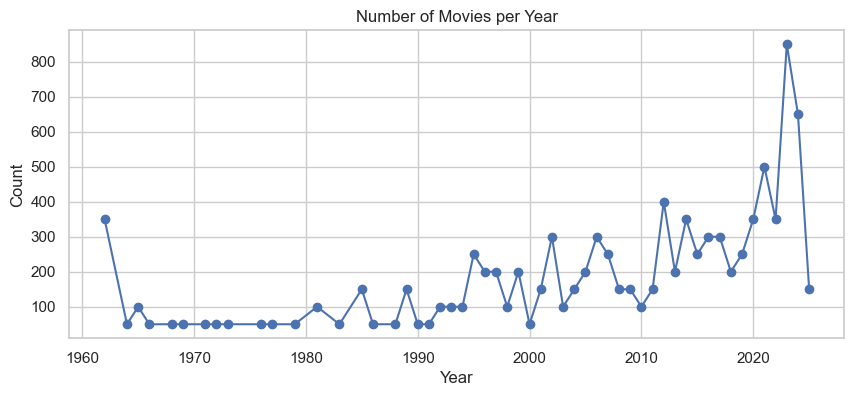

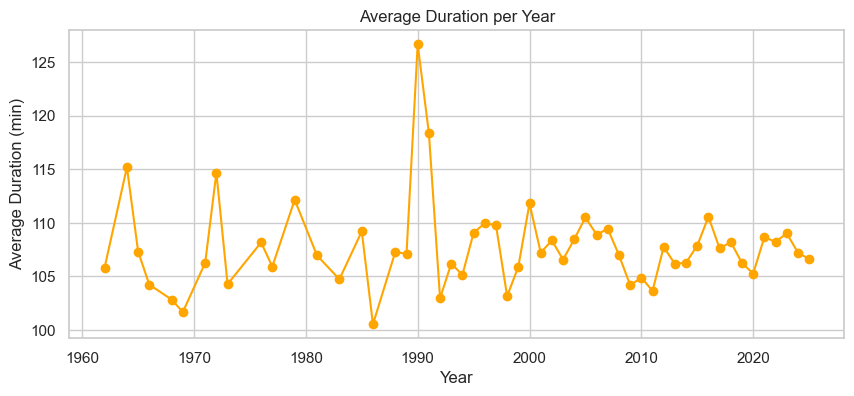

In [16]:
if 'year' in df_clean.columns:
    yearly_count = df_clean.groupby('year').size()
    plt.figure(figsize=(10,4))
    yearly_count.plot(kind='line', marker='o')
    plt.title('Number of Movies per Year')
    plt.xlabel('Year')
    plt.ylabel('Count')
    plt.show()

    if 'duration' in df_clean.columns:
        yearly_duration = df_clean.groupby('year')['duration'].mean()
        plt.figure(figsize=(10,4))
        yearly_duration.plot(kind='line', marker='o', color='orange')
        plt.title('Average Duration per Year')
        plt.xlabel('Year')
        plt.ylabel('Average Duration (min)')
        plt.show()
else:
    print('No year column found in df_clean')

## Scatter plots: meta score vs duration, meta score vs year (movie-level)


In [17]:
if {'meta_score','duration'}.issubset(df_clean.columns):
    plt.figure(figsize=(6,4))
    sns.scatterplot(data=df_clean, x='duration', y='meta_score', alpha=0.7)
    plt.title('Meta Score vs Duration')
    plt.xlabel('Duration (min)')
    plt.ylabel('Meta Score')
    plt.show()

if {'meta_score','year'}.issubset(df_clean.columns):
    plt.figure(figsize=(6,4))
    sns.scatterplot(data=df_clean, x='year', y='meta_score', alpha=0.7)
    plt.title('Meta Score vs Year')
    plt.xlabel('Year')
    plt.ylabel('Meta Score')
    plt.show()

## Boxplots by genre (genre-level)

Distribution of duration and meta score by genre using the genre-exploded dataset.


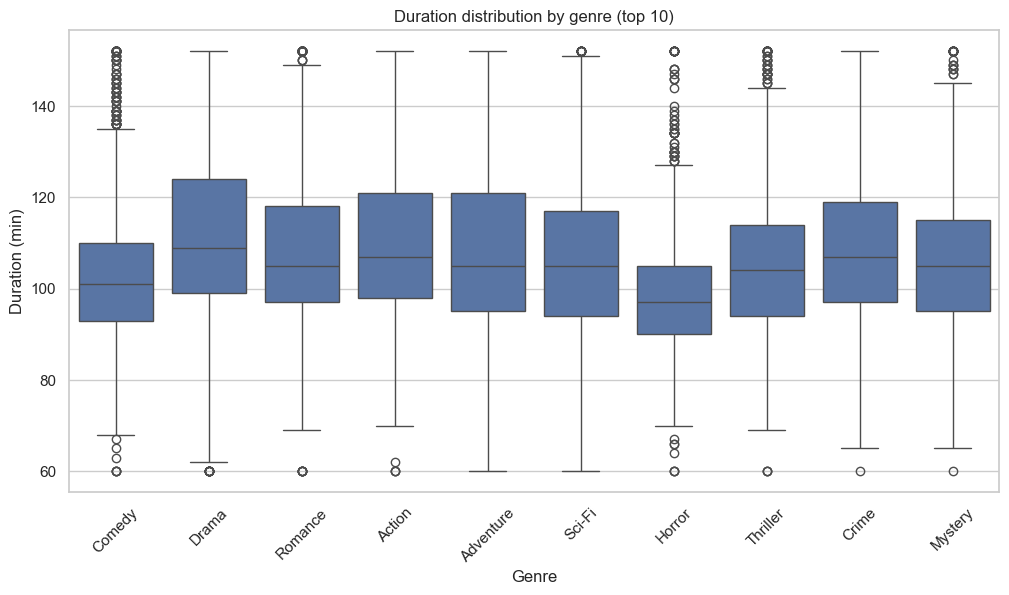

Genre column not found or insufficient numeric columns in df_genre for boxplots.


In [18]:
if {'genre','duration'}.issubset(df_genre.columns):
    plt.figure(figsize=(12,6))
    top_genres = df_genre['genre'].value_counts().head(10).index.tolist()
    sns.boxplot(data=df_genre[df_genre['genre'].isin(top_genres)], x='genre', y='duration')
    plt.title('Duration distribution by genre (top 10)')
    plt.xlabel('Genre')
    plt.ylabel('Duration (min)')
    plt.xticks(rotation=45)
    plt.show()

if {'genre','meta_score'}.issubset(df_genre.columns):
    plt.figure(figsize=(12,6))
    top_genres = df_genre['genre'].value_counts().head(10).index.tolist()
    sns.boxplot(data=df_genre[df_genre['genre'].isin(top_genres)], x='genre', y='meta_score')
    plt.title('Meta score distribution by genre (top 10)')
    plt.xlabel('Genre')
    plt.ylabel('Meta Score')
    plt.xticks(rotation=45)
    plt.show()
else:
    print('Genre column not found or insufficient numeric columns in df_genre for boxplots.')

## Cross-view summaries

- Movie-level (df_clean): general distributions, correlations, yearly trends.
- Cast-level (df_cast): frequency of actors, average meta score by actor.
- Genre-level (df_genre): frequency of genres, average meta score by genre, boxplots.
